# Library

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import ta
import pandas_datareader.data as web

np.random.seed(42)

# Dataset NASDAQ

In [3]:
nasdaq = 'FR0011871110'

start = datetime.datetime(2014, 8, 1)
end = datetime.datetime.today().date()

def get_data(ticker, start, end):
    data = yf.Ticker(ticker).history(period='1d', start=start, end=end)
    data.set_index(pd.to_datetime(pd.Series(data.index).apply(lambda x: str(x)[0:10])))
    data.index = pd.to_datetime(data.index)
    data.reset_index(inplace=True)
    data["Date"] = data["Date"].dt.tz_localize(None).dt.date
    data.set_index('Date', inplace=True)
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    print(f"Données de {ticker} - {data.index[0]} - {data.index[-1]}")
    return data
    
df = get_data(nasdaq, start, end)

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)
Données de FR0011871110 - 2014-08-01 - 2025-05-23


# Variables

In [5]:
# Log returns
df.loc[:, 'returns'] = df['Close'].pct_change()

# Momentum
df.loc[:, 'momentum'] = df['Close']/df['Close'].shift(10)

# Ratio LCR
df.loc[:, 'LCR'] = (df['Low']/df['Close'])

# Ratio LCR
df.loc[:, 'HCR'] = (df['High']/df['Close'])

# Ratio DCR
df.loc[:, 'DCR'] = df['HCR'] / df['LCR']

# Split

In [9]:
features = ['returns', 'momentum', 'DCR']

df.index = pd.to_datetime(df.index)

train_features = df.loc['2014':'2019'].copy()[features]
test_features = df.loc['2020':'2025'].copy()[features]

# Transformer

In [11]:
from sklearn.preprocessing import MaxAbsScaler

dfs = df.copy()[['Close', 'returns', 'momentum', 'DCR']]

scaler = MaxAbsScaler()

train_features = pd.DataFrame(scaler.fit_transform(train_features.dropna()), columns=train_features.columns, index=train_features.dropna().index).dropna()
train_features.index = pd.to_datetime(train_features.index)

train_data = train_features[features].values.reshape(-1, len(features))

# Correlation 

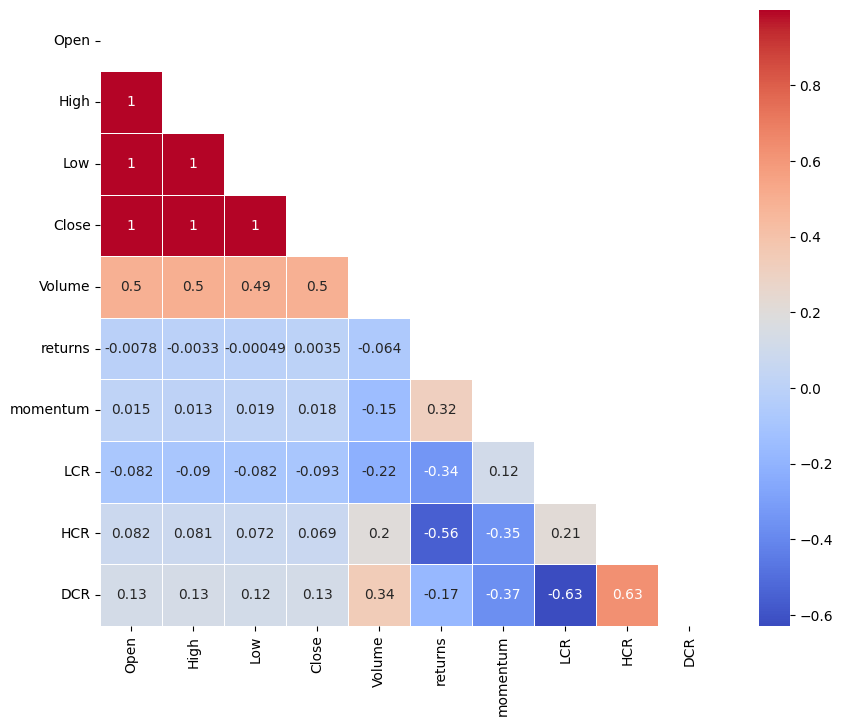

In [13]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()

# Model HMM

In [15]:
def market_regime_type(data, x):

    pivot = data.groupby('market_regime')['returns'].mean()

    min_val = pivot.idxmin()
    max_val = pivot.idxmax()

    if x == min_val:
        return 'bearish'
    elif x == max_val:
        return 'bullish'
    else:
        return 'range'

model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=50000, algorithm='map', tol=1e-6, init_params="cmw")
model.fit(train_data)

train_features['market_regime'] = model.predict(train_data)
train_features['market_regime_type'] = train_features['market_regime'].apply(lambda x: market_regime_type(train_features, x))

Model is not converging.  Current: 8884.157175115899 is not greater than 8885.48191254364. Delta is -1.3247374277416384


# Simulation

In [17]:
data_test_slow = test_features.copy()

market_regime_predictions = []
bearish_signal_force = []

state_means = train_features.groupby(['market_regime', 'market_regime_type'])['returns'].mean()
state_means_dict = {
                    state_means.index[0][1]: state_means.index[0][0],
                     state_means.index[1][1]: state_means.index[1][0]
                   }

for i in range(len(data_test_slow)):

    current_row_features = data_test_slow[features].iloc[:i+1]
    
    current_prediction = model.predict(scaler.transform(current_row_features))[0]
    market_regime_predictions.append(current_prediction)
    
    current_prob_prediction = model.predict_proba(scaler.transform(current_row_features))
    bearish_prob_reach = state_means_dict['bearish']
    bearish_signal_force.append(round(current_prob_prediction[-1][bearish_prob_reach], 2))
    
data_test_slow['market_regime'] = market_regime_predictions
data_test_slow['bearish_signal_force'] = bearish_signal_force
data_test_slow['bullish_signal_force'] = 1 - data_test_slow['bearish_signal_force']
data_test_slow['market_regime'] = data_test_slow['market_regime'].apply(lambda x: market_regime_type(data_test_slow, x))

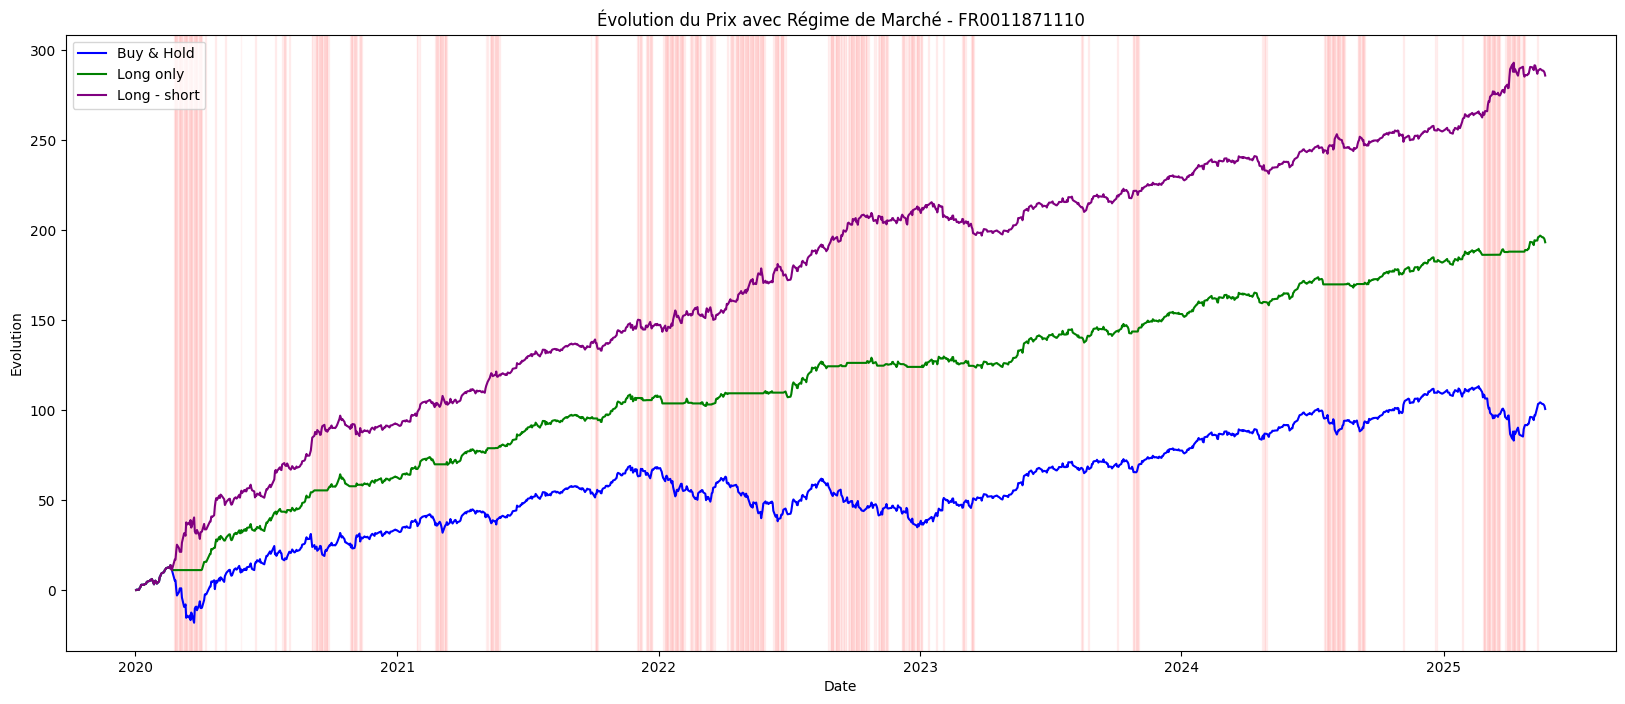

In [21]:
data_test_slow['Close unscaled'] = df['Close']	

# Instant signal ≥ 0.95 or 3 cumulatives signal low ≥ 0.9
signal_bearish_strong = data_test_slow['bearish_signal_force'] >= 0.95
signal_bearish_steady = (
    (data_test_slow['bearish_signal_force'] >= 0.9)
    .rolling(window=3)
    .apply(lambda x: x.all(), raw=True)
    .fillna(0)
    .astype(bool)
)
data_test_slow['signal_bearish'] = (signal_bearish_strong | signal_bearish_steady).astype(int)

signal_bullish_strong = data_test_slow['bullish_signal_force'] >= 0.95
signal_bullish_steady = (
    (data_test_slow['bullish_signal_force'] >= 0.9)
    .rolling(window=3)
    .apply(lambda x: x.all(), raw=True)
    .fillna(0)
    .astype(bool)
)
data_test_slow['signal_bullish'] = (signal_bullish_strong | signal_bullish_steady).astype(int)

data_test_slow['Buy & Hold'] = data_test_slow['Close unscaled'].pct_change().cumsum()*100
data_test_slow['Long only'] = data_test_slow['Close unscaled'].pct_change().where(data_test_slow['signal_bearish'] == 0).fillna(0).cumsum()*100
data_test_slow['Long - Short'] = np.where(
    data_test_slow['signal_bearish'] == 0,
    data_test_slow['Close unscaled'].pct_change(),
    np.where(
        data_test_slow['signal_bullish'] == 0,
        -data_test_slow['Close unscaled'].pct_change(),
        0
    )
)
data_test_slow['Long - Short'] = data_test_slow['Long - Short'].fillna(0).cumsum() * 100

def rightPos(row):
    if row['signal_bearish'] and not row['signal_bullish']:
        return 'SHORT'
    elif row['signal_bullish'] and not row['signal_bearish']:
        return 'LONG'
    else:
        return 'FLAT' 

data_test_slow['Position'] = data_test_slow.apply(rightPos, axis=1)
data_test_slow['Position'] = data_test_slow['Position'].replace('FLAT', np.nan).ffill()

# Plot

data_graph = data_test_slow.copy()

fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(data_graph.index, data_graph['Buy & Hold'], label='Buy & Hold', color='blue')
ax.plot(data_graph.index, data_graph['Long only'], label='Long only', color='green')
ax.plot(data_graph.index, data_graph['Long - Short'], label='Long - short', color='purple')

for i in range(len(data_graph) - 1):
    if data_graph.iloc[i]['signal_bearish'] == 1:
        ax.axvspan(data_graph.index[i], data_graph.index[i + 1], color='red', alpha=0.05)  # Rouge pour bearish

ax.set_title(f"Évolution du Prix avec Régime de Marché - {nasdaq}")
ax.set_xlabel("Date")
ax.set_ylabel("Evolution")
ax.legend()
plt.show()

## Backtest

In [23]:
def backtest(df, initial_wallet=1000, fee_rate=0.001, fee_fixed_per_order=1.25, short_daily_rate=0.0001):
    df = df.copy()
    df = df[df['Position'].isin(['LONG', 'SHORT'])]
    df = df.sort_index()

    trades = []
    wallet = initial_wallet
    current_position = None
    entry_price = None
    entry_date = None

    for current_date, row in df.iterrows():
        price = row['Close unscaled']
        position = row['Position']

        if current_position is None:
            # New position
            current_position = position
            entry_price = price
            entry_date = current_date
            wallet -= fee_fixed_per_order  # fixed entry fee
            continue

        if position != current_position:
            # Close previous position
            exit_price = price
            exit_date = current_date

            holding_days = (exit_date - entry_date).days
            if holding_days == 0:
                holding_days = 1  # avoid 0 day

            if current_position == 'LONG':
                pnl = (exit_price - entry_price) / entry_price
                short_interest_fee = 0  
            elif current_position == 'SHORT':
                pnl = (entry_price - exit_price) / entry_price
                # Apply interest rate short
                short_interest_fee = wallet * short_daily_rate * (holding_days -1)
            else:
                short_interest_fee = 0

            gross_profit = wallet * pnl
            wallet += gross_profit
            wallet -= fee_fixed_per_order  # frais fixe de sortie
            wallet -= short_interest_fee  # si short, appliquer intérêts


            trades.append({
                'open_date': entry_date,
                'close_date': exit_date,
                'open_price': entry_price,
                'close_price': exit_price,
                'position': current_position,
                'gross_profit': gross_profit,
                'exit_fee': fee_fixed_per_order,
                'entry_fee': fee_fixed_per_order,
                'short_interest_fee': short_interest_fee,
                'holding_days': holding_days,
                'wallet': wallet
            })

            # New position
            current_position = position
            entry_price = price
            entry_date = current_date
            wallet -= fee_fixed_per_order  # frais d’entrée nouvelle position

    return pd.DataFrame(trades)
    
trades = backtest(data_test_slow, initial_wallet= 10000, fee_rate=0.001)

trades.open_date = pd.to_datetime(trades.open_date)
trades.index = trades.open_date
trades.tail(10)

,open_date,close_date,open_price,close_price,position,gross_profit,exit_fee,entry_fee,short_interest_fee,holding_days,wallet
open_date,,,,,,,,,,,
2024-11-08,2024-11-08,2024-12-20,78.879997,82.480003,LONG,1111.111128,1.25,1.25,0.000000,42,25455.498376
2024-12-20,2024-12-20,2024-12-24,82.480003,83.169998,SHORT,-212.940090,1.25,1.25,7.636275,4,25232.422012
2024-12-24,2024-12-24,2025-01-27,83.169998,80.550003,LONG,-794.824443,1.25,1.25,0.000000,34,24435.097569
2025-01-27,2025-01-27,2025-02-04,80.550003,83.339996,SHORT,-846.309970,1.25,1.25,17.103693,8,23569.183905
2025-02-04,2025-02-04,2025-02-25,83.339996,80.099998,LONG,-916.247407,1.25,1.25,0.000000,21,22650.436499
2025-02-25,2025-02-25,2025-03-25,80.099998,75.050003,SHORT,1427.943699,1.25,1.25,61.152804,28,24014.727395
2025-03-25,2025-03-25,2025-03-28,75.050003,71.620003,LONG,-1097.484763,1.25,1.25,0.000000,3,22914.742632
2025-03-28,2025-03-28,2025-04-28,71.620003,67.820000,SHORT,1215.740556,1.25,1.25,68.740478,31,24059.242710
2025-04-28,2025-04-28,2025-05-12,67.820000,74.750000,LONG,2458.299876,1.25,1.25,0.000000,14,26515.042585


Performances wallet : 143.5%
B&H : 139.0%


<Axes: xlabel='open_date'>

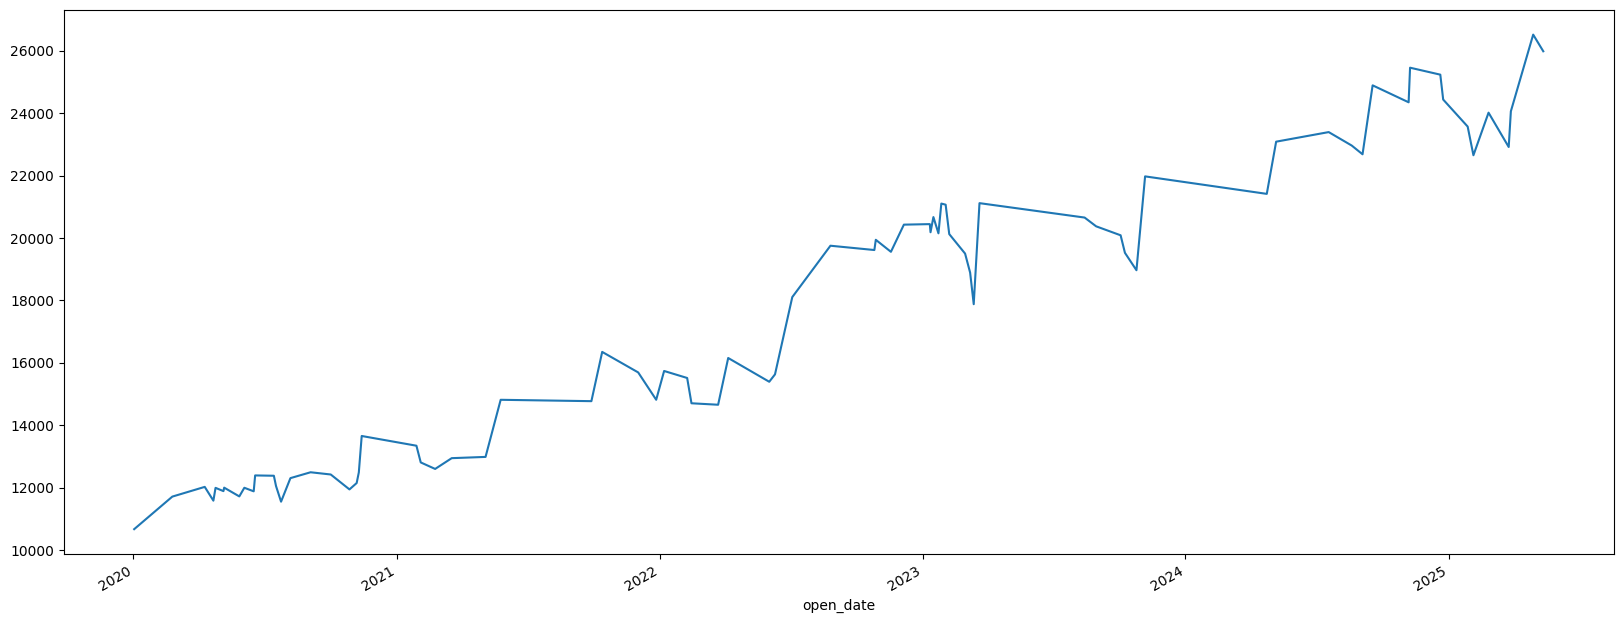

In [25]:
calc = df.loc[test_features.index.min():test_features.index.max()].copy()

print(f"Performances wallet : {round(((trades['wallet'].iloc[-1] - trades['wallet'].iloc[0]) / trades['wallet'].iloc[0])*100, 1)}%")
print(f"B&H : {round(((calc['Close'].iloc[-1] - calc['Close'].iloc[0]) / calc['Close'].iloc[0])*100, 1)}%")
plt.figure(figsize=(20, 8))
trades['wallet'].plot()